## Bibliotecas

In [5]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

!pip install matplotlib --quiet
!pip install -U aeon --quiet
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
from aeon.transformations.collection.convolution_based._rocket import *
from aeon.datasets._data_loaders import load_classification
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score

## Separação dos dados e treinamento

In [6]:
x_train, y_train = load_classification("CinCECGTorso", split='train')
x_test, y_test = load_classification("CinCECGTorso", split='test')
rck = Rocket(num_kernels=1000)

x_train_feat = rck.fit_transform(x_train)

x_transformado = rck._transform(x_train) #matriz transformada com ppv(pares) e max(ímpares)

In [7]:
x_train_feat.shape

(40, 2000)

## Separação das features

In [8]:
# ppv (começa em 0, vai até o final, pula de 2 em 2)
x_transformado[:,::2]

array([[0.09334961, 0.9585113 , 0.3854069 , ..., 0.6180602 , 0.25906736,
        0.643743  ],
       [0.06528371, 0.94752896, 0.4630496 , ..., 0.55518395, 0.45891932,
        0.51972944],
       [0.04209884, 0.9548505 , 0.4686623 , ..., 0.68561876, 0.33678755,
        0.626832  ],
       ...,
       [0.04881025, 0.96217203, 0.4340505 , ..., 0.6869565 , 0.36565506,
        0.53889513],
       [0.15924343, 0.9389872 , 0.5444341 , ..., 0.6541806 , 0.2524056 ,
        0.518602  ],
       [0.04270897, 0.9609518 , 0.44901776, ..., 0.6555184 , 0.3330866 ,
        0.5501691 ]], dtype=float32)

In [9]:
x_transformado[:,1::2] # max

array([[ 7.8790717, 11.010512 , 24.287193 , ..., 12.419212 , 16.675964 ,
         9.2058325],
       [ 3.1870275,  8.296057 , 13.261282 , ..., 13.9635315,  9.594975 ,
         5.788746 ],
       [ 3.6745949,  5.861831 , 14.757269 , ..., 14.035288 ,  8.600897 ,
         5.1583076],
       ...,
       [ 3.0367696,  6.967434 , 17.031927 , ..., 12.131406 , 21.28354  ,
        11.720846 ],
       [ 6.5635066,  6.8957744, 14.4166565, ..., 11.207283 , 15.047707 ,
        12.067814 ],
       [ 3.175581 ,  7.0435963, 13.827162 , ..., 12.785243 , 18.649136 ,
         9.998221 ]], dtype=float32)

## Análise dos valores do ppv

<function matplotlib.pyplot.show(close=None, block=None)>

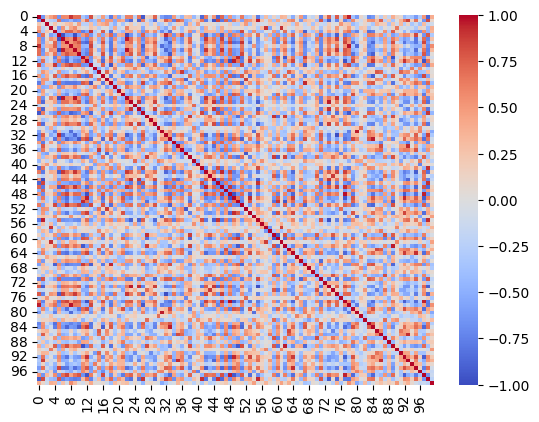

In [10]:
correlation_matrix1 = np.corrcoef(x_transformado[:,0:200:2].T)#seleciona todas as linhas, colunas de 0 a 36 pulando de 2 em 2(0,2,4,6,..., pares valores PPV)
sns.heatmap(correlation_matrix1, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

In [11]:
np.min(correlation_matrix1)

-0.9945452287425195

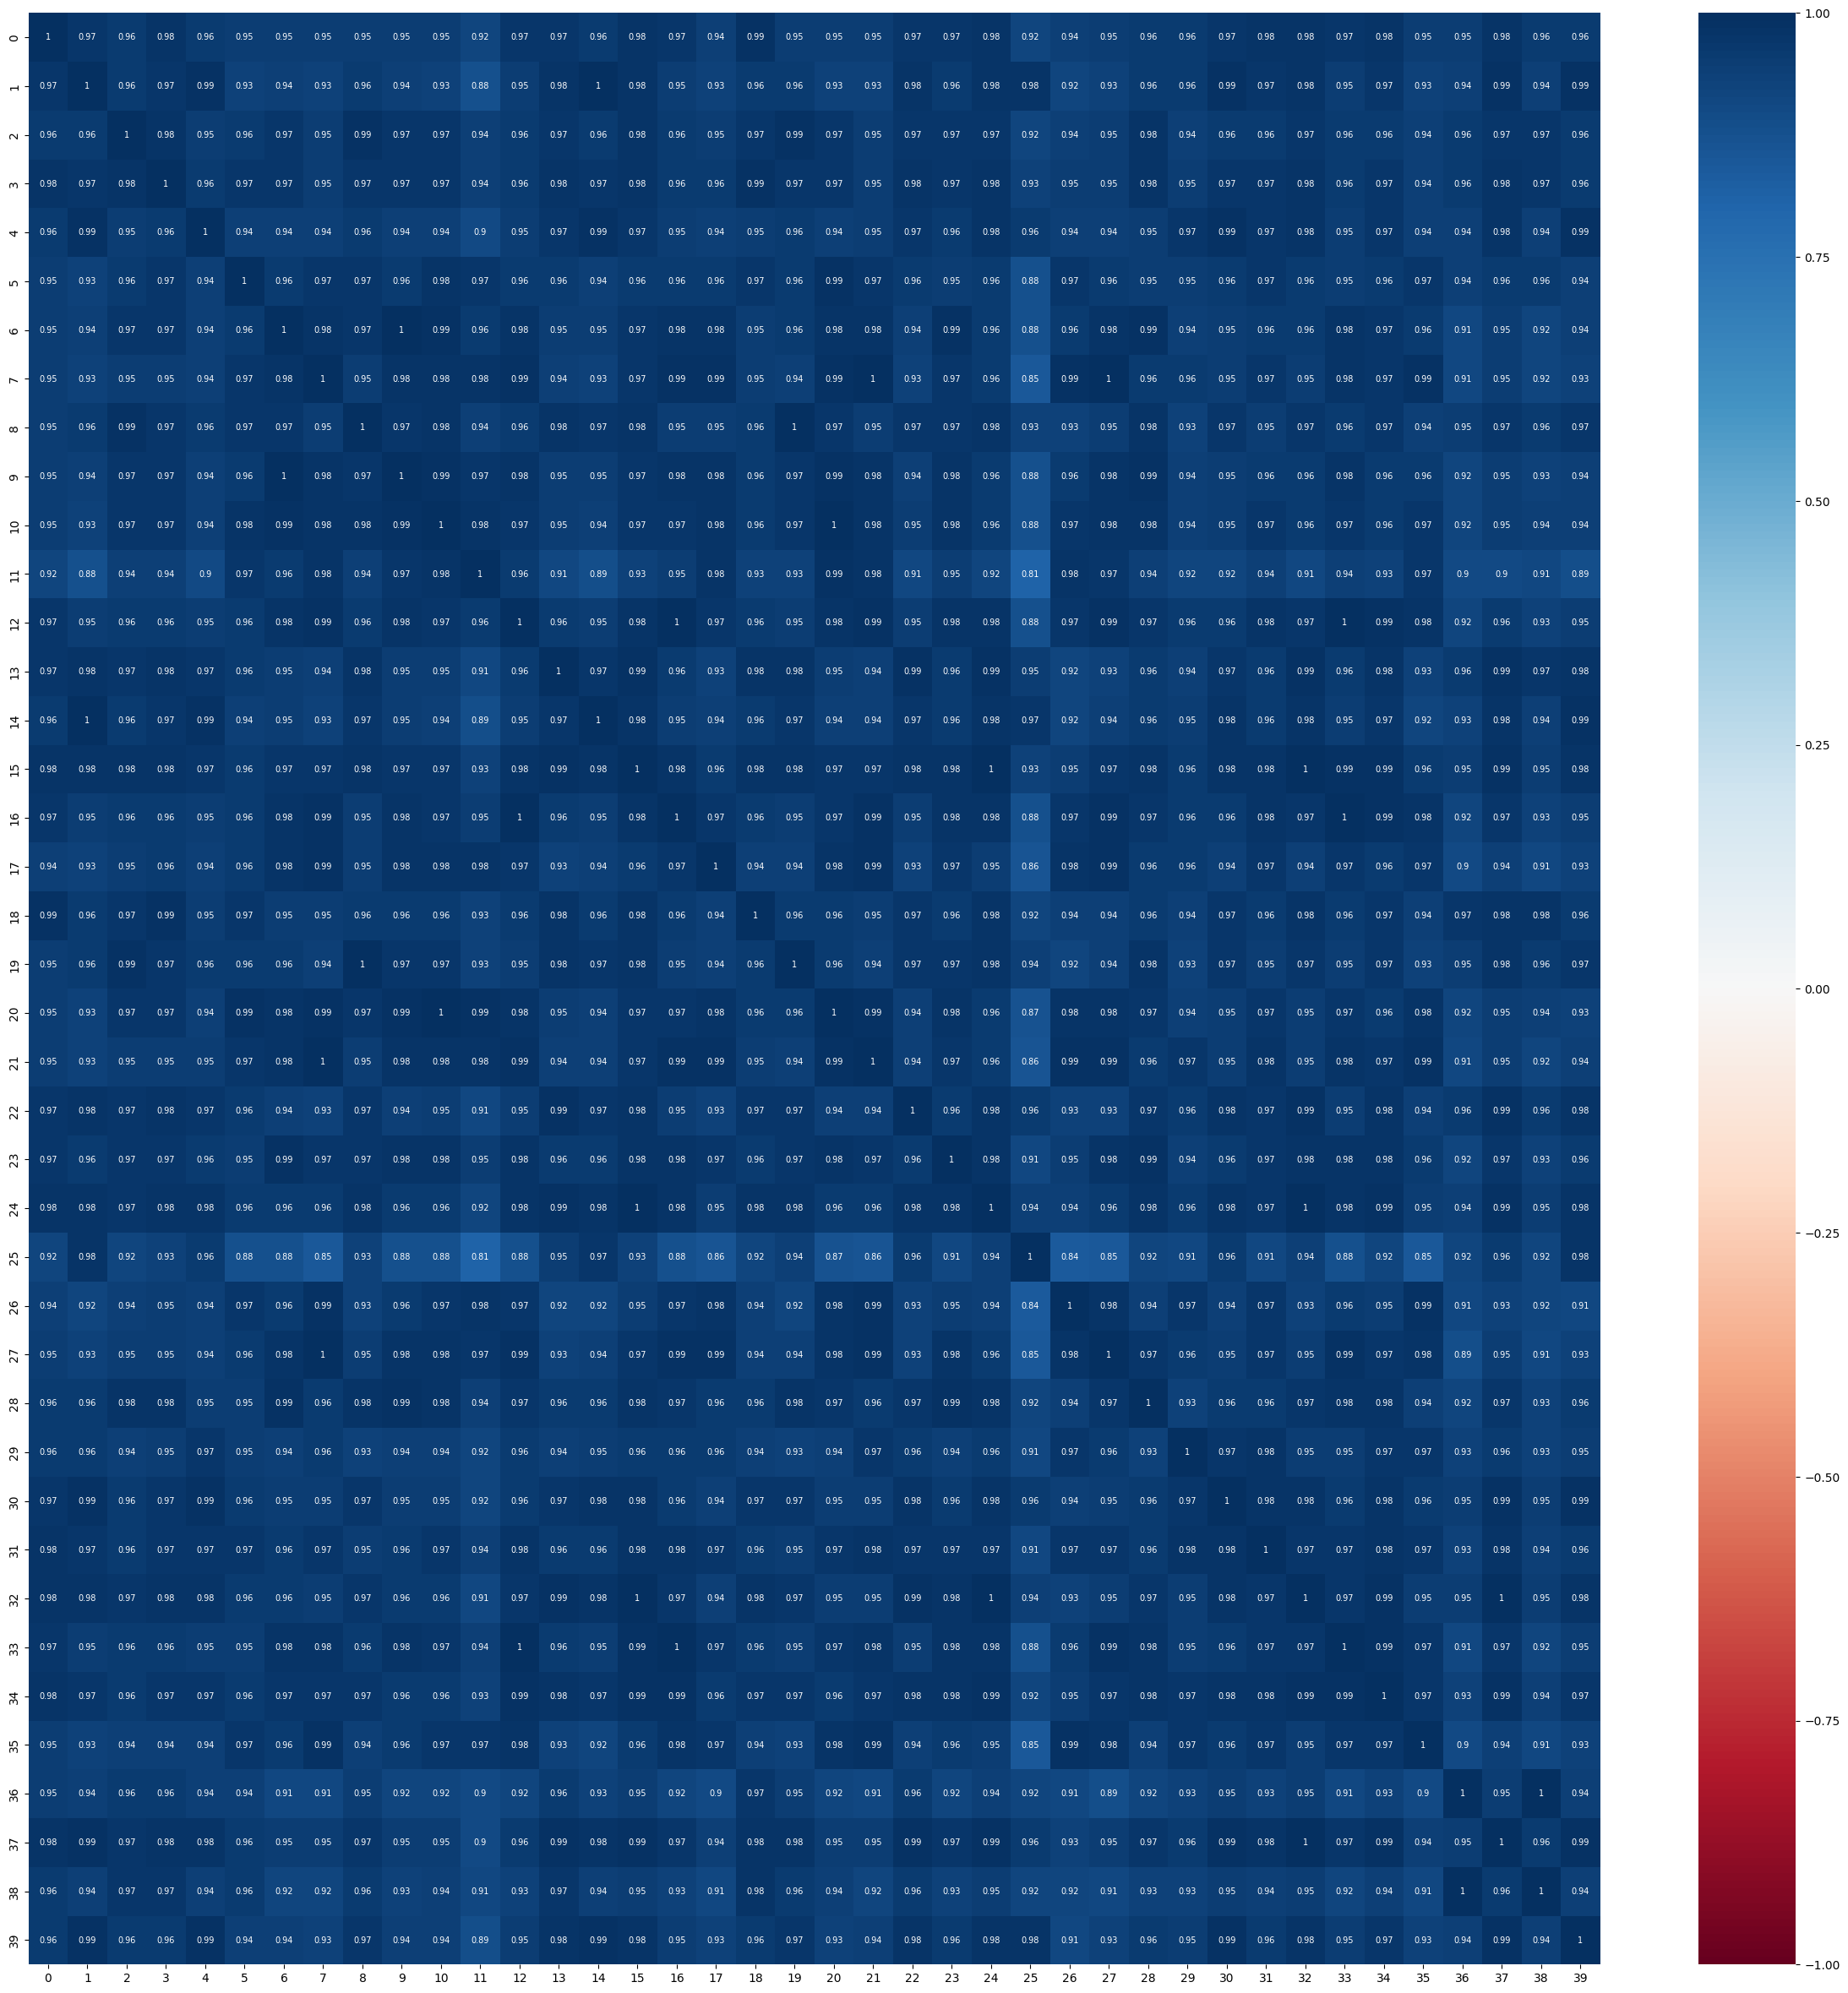

In [12]:
ecg200ppv = pd.DataFrame(x_transformado[:,0:100:2].T)
plt.figure(figsize=(30,30))
correlations1 = ecg200ppv.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

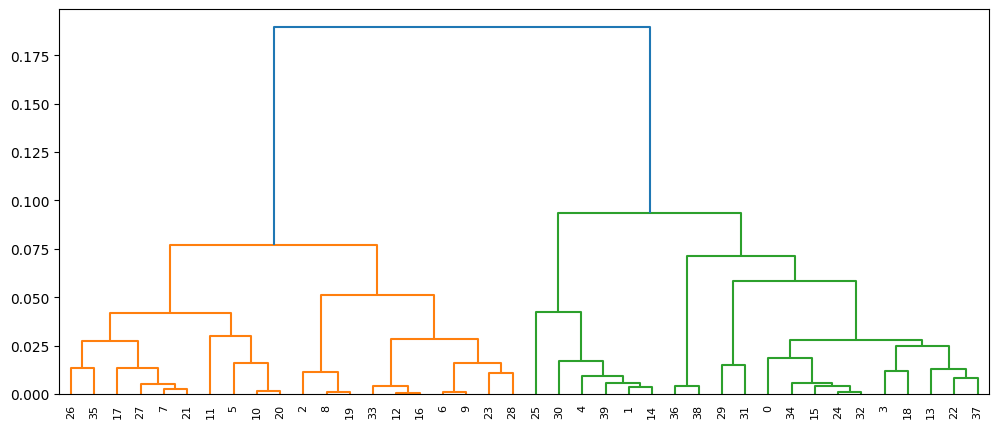

In [13]:
plt.figure(figsize=(12,5))
dissimilarity1 = 1 - abs(correlations1)
Z = linkage(squareform(dissimilarity1), 'complete')

dendrogram(Z, labels=ecg200ppv.columns, orientation='top',
           leaf_rotation=90);

In [14]:
# Clusterize the data
threshold = 0.000005 #dissimilaridade (distancia) entre dois clusters
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([35, 21, 13, 36, 24,  9, 17,  3, 11, 18,  7, 10, 14, 40, 22, 33, 15,
        6, 37, 12,  8,  4, 38, 19, 31, 26,  1,  5, 20, 29, 25, 30, 32, 16,
       34,  2, 27, 39, 28, 23], dtype=int32)

In [15]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(ecg200ppv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ecg200ppv[i])
    else:
        df_to_append = pd.DataFrame(ecg200ppv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

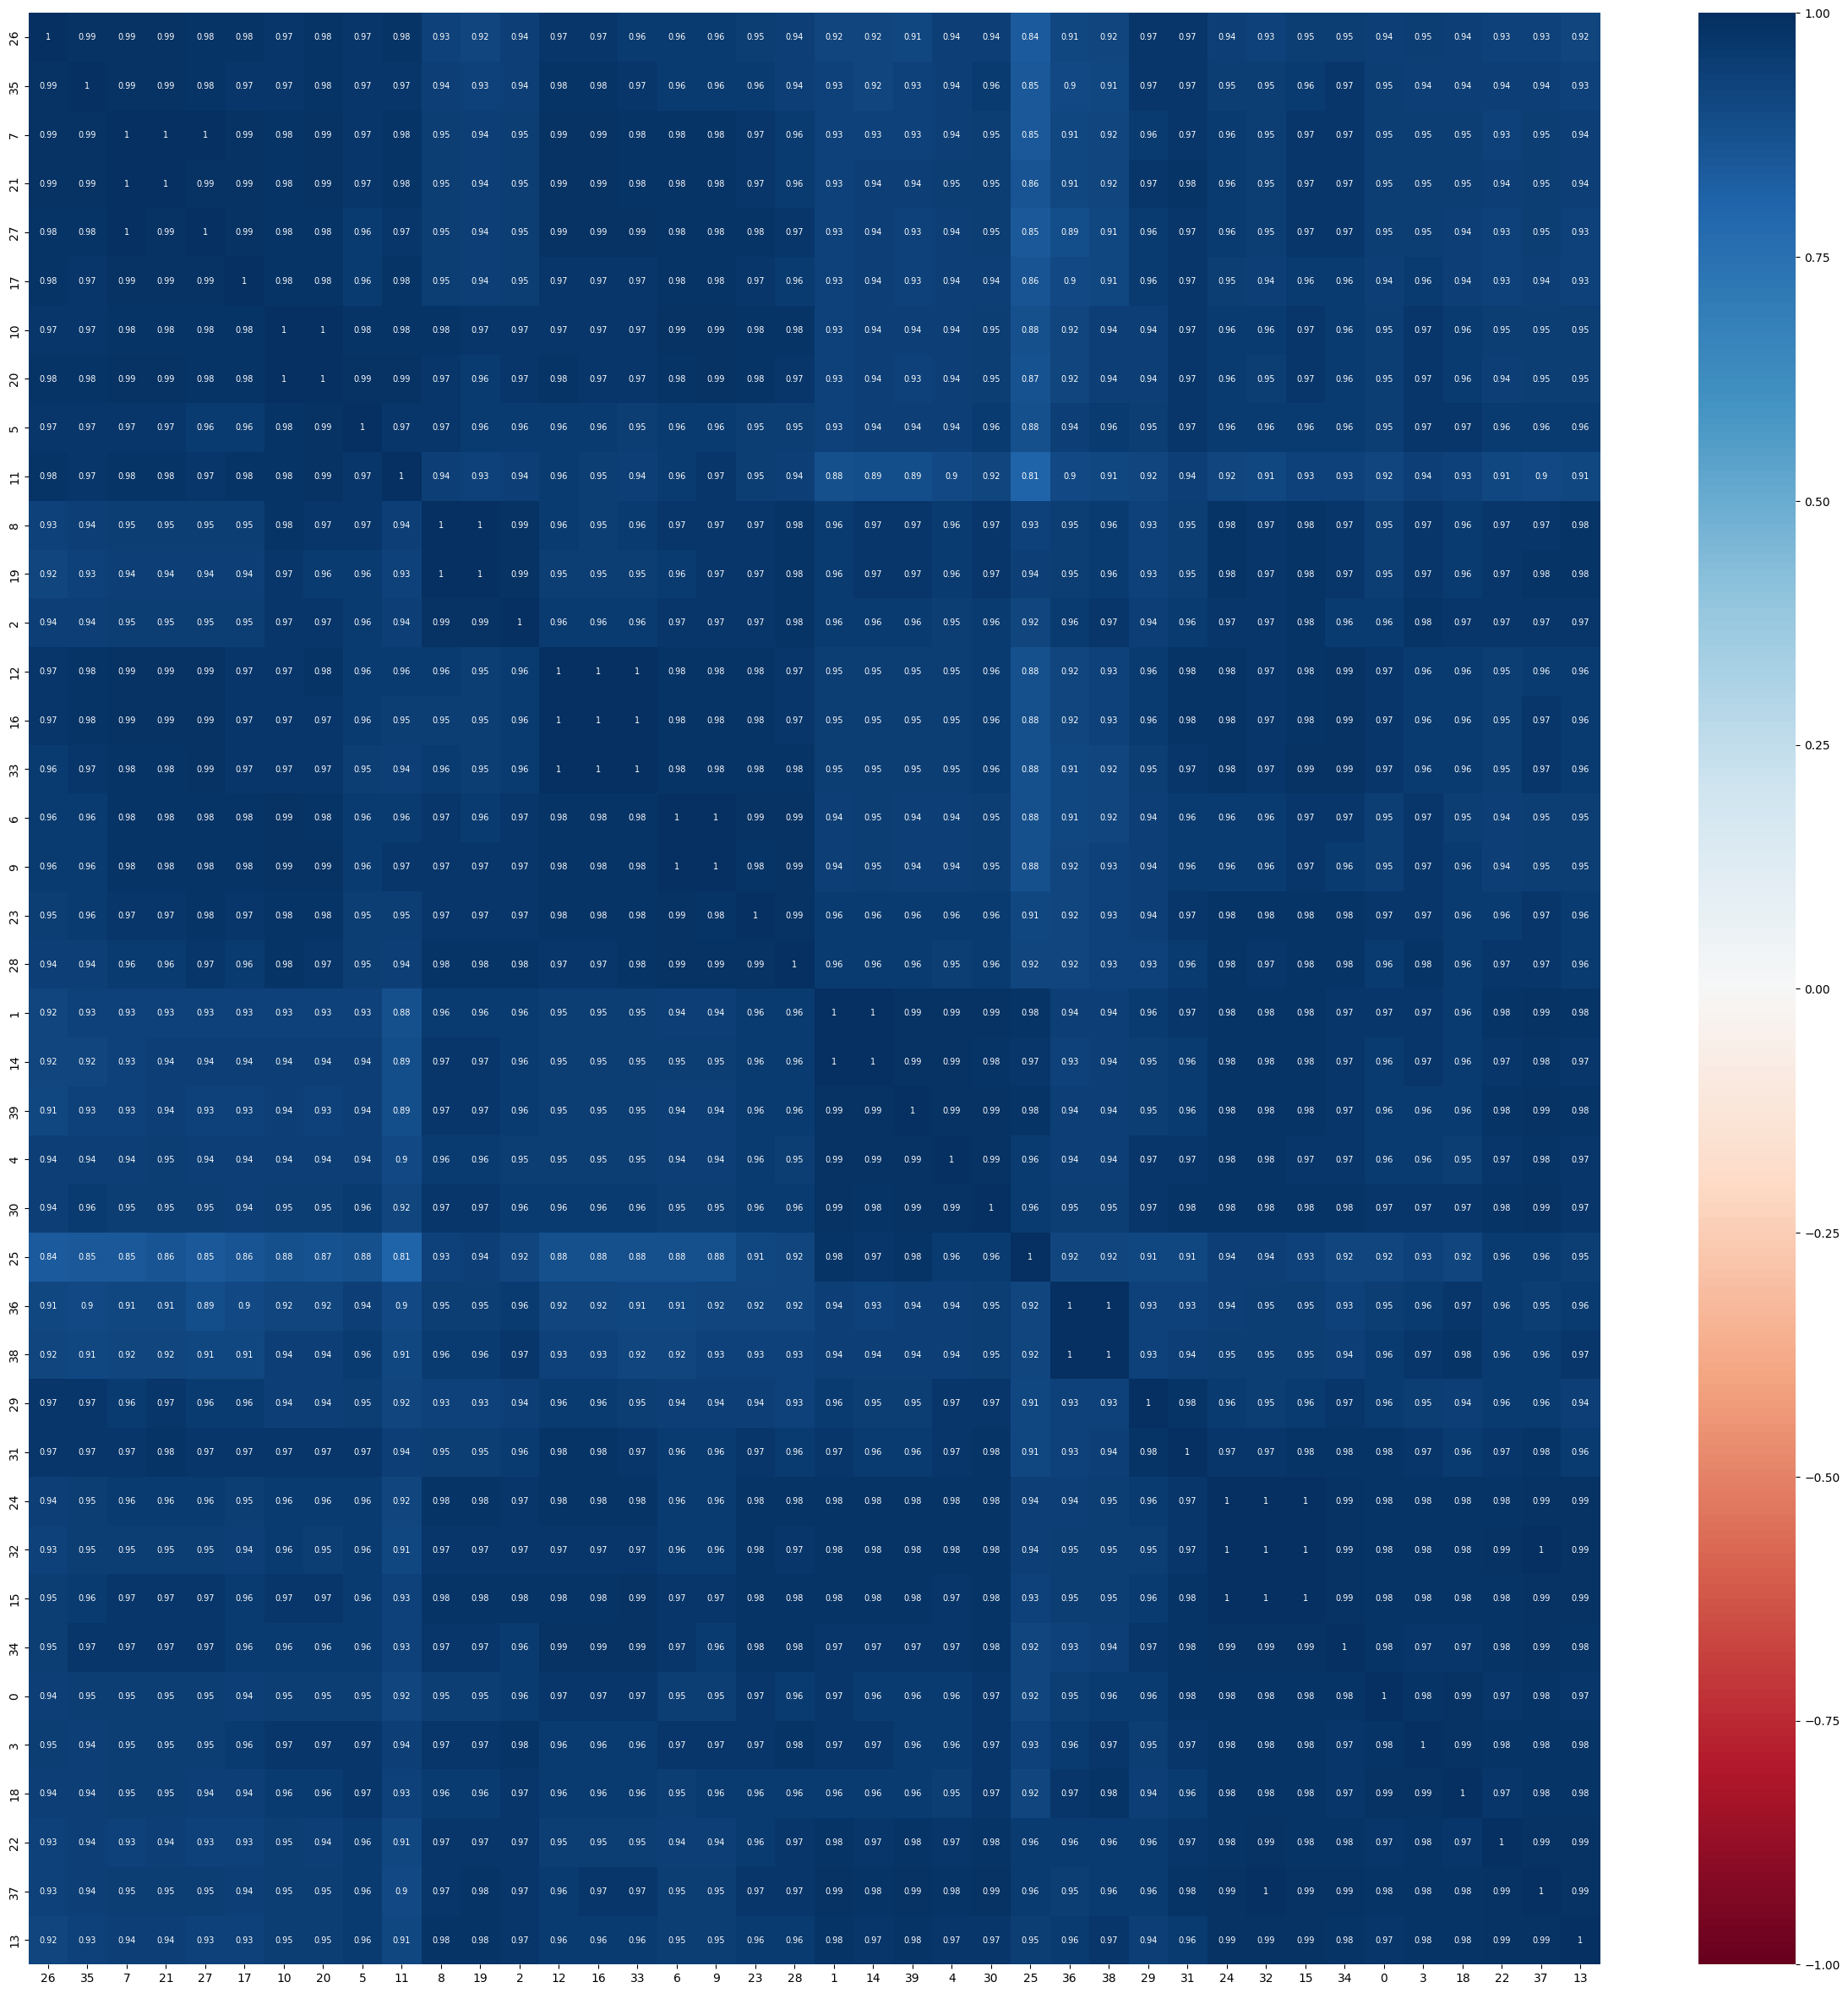

In [16]:
plt.figure(figsize=(30,30))
correlations1 = clustered.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

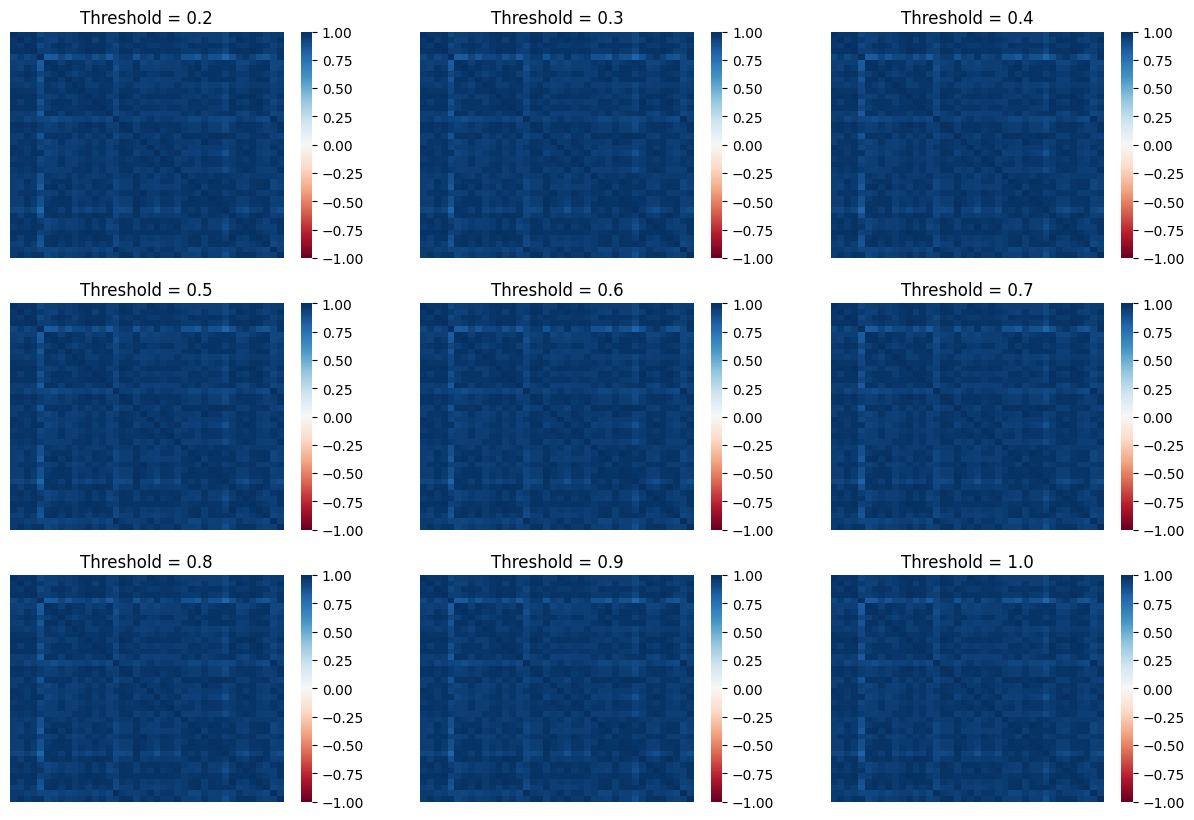

In [17]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):

    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)

    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(ecg200ppv.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(ecg200ppv[i])
        else:
            df_to_append = pd.DataFrame(ecg200ppv[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    # Plot the correlation heatmap
    correlations1 = clustered.corr()
    sns.heatmap(round(correlations1,2), cmap='RdBu', vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))

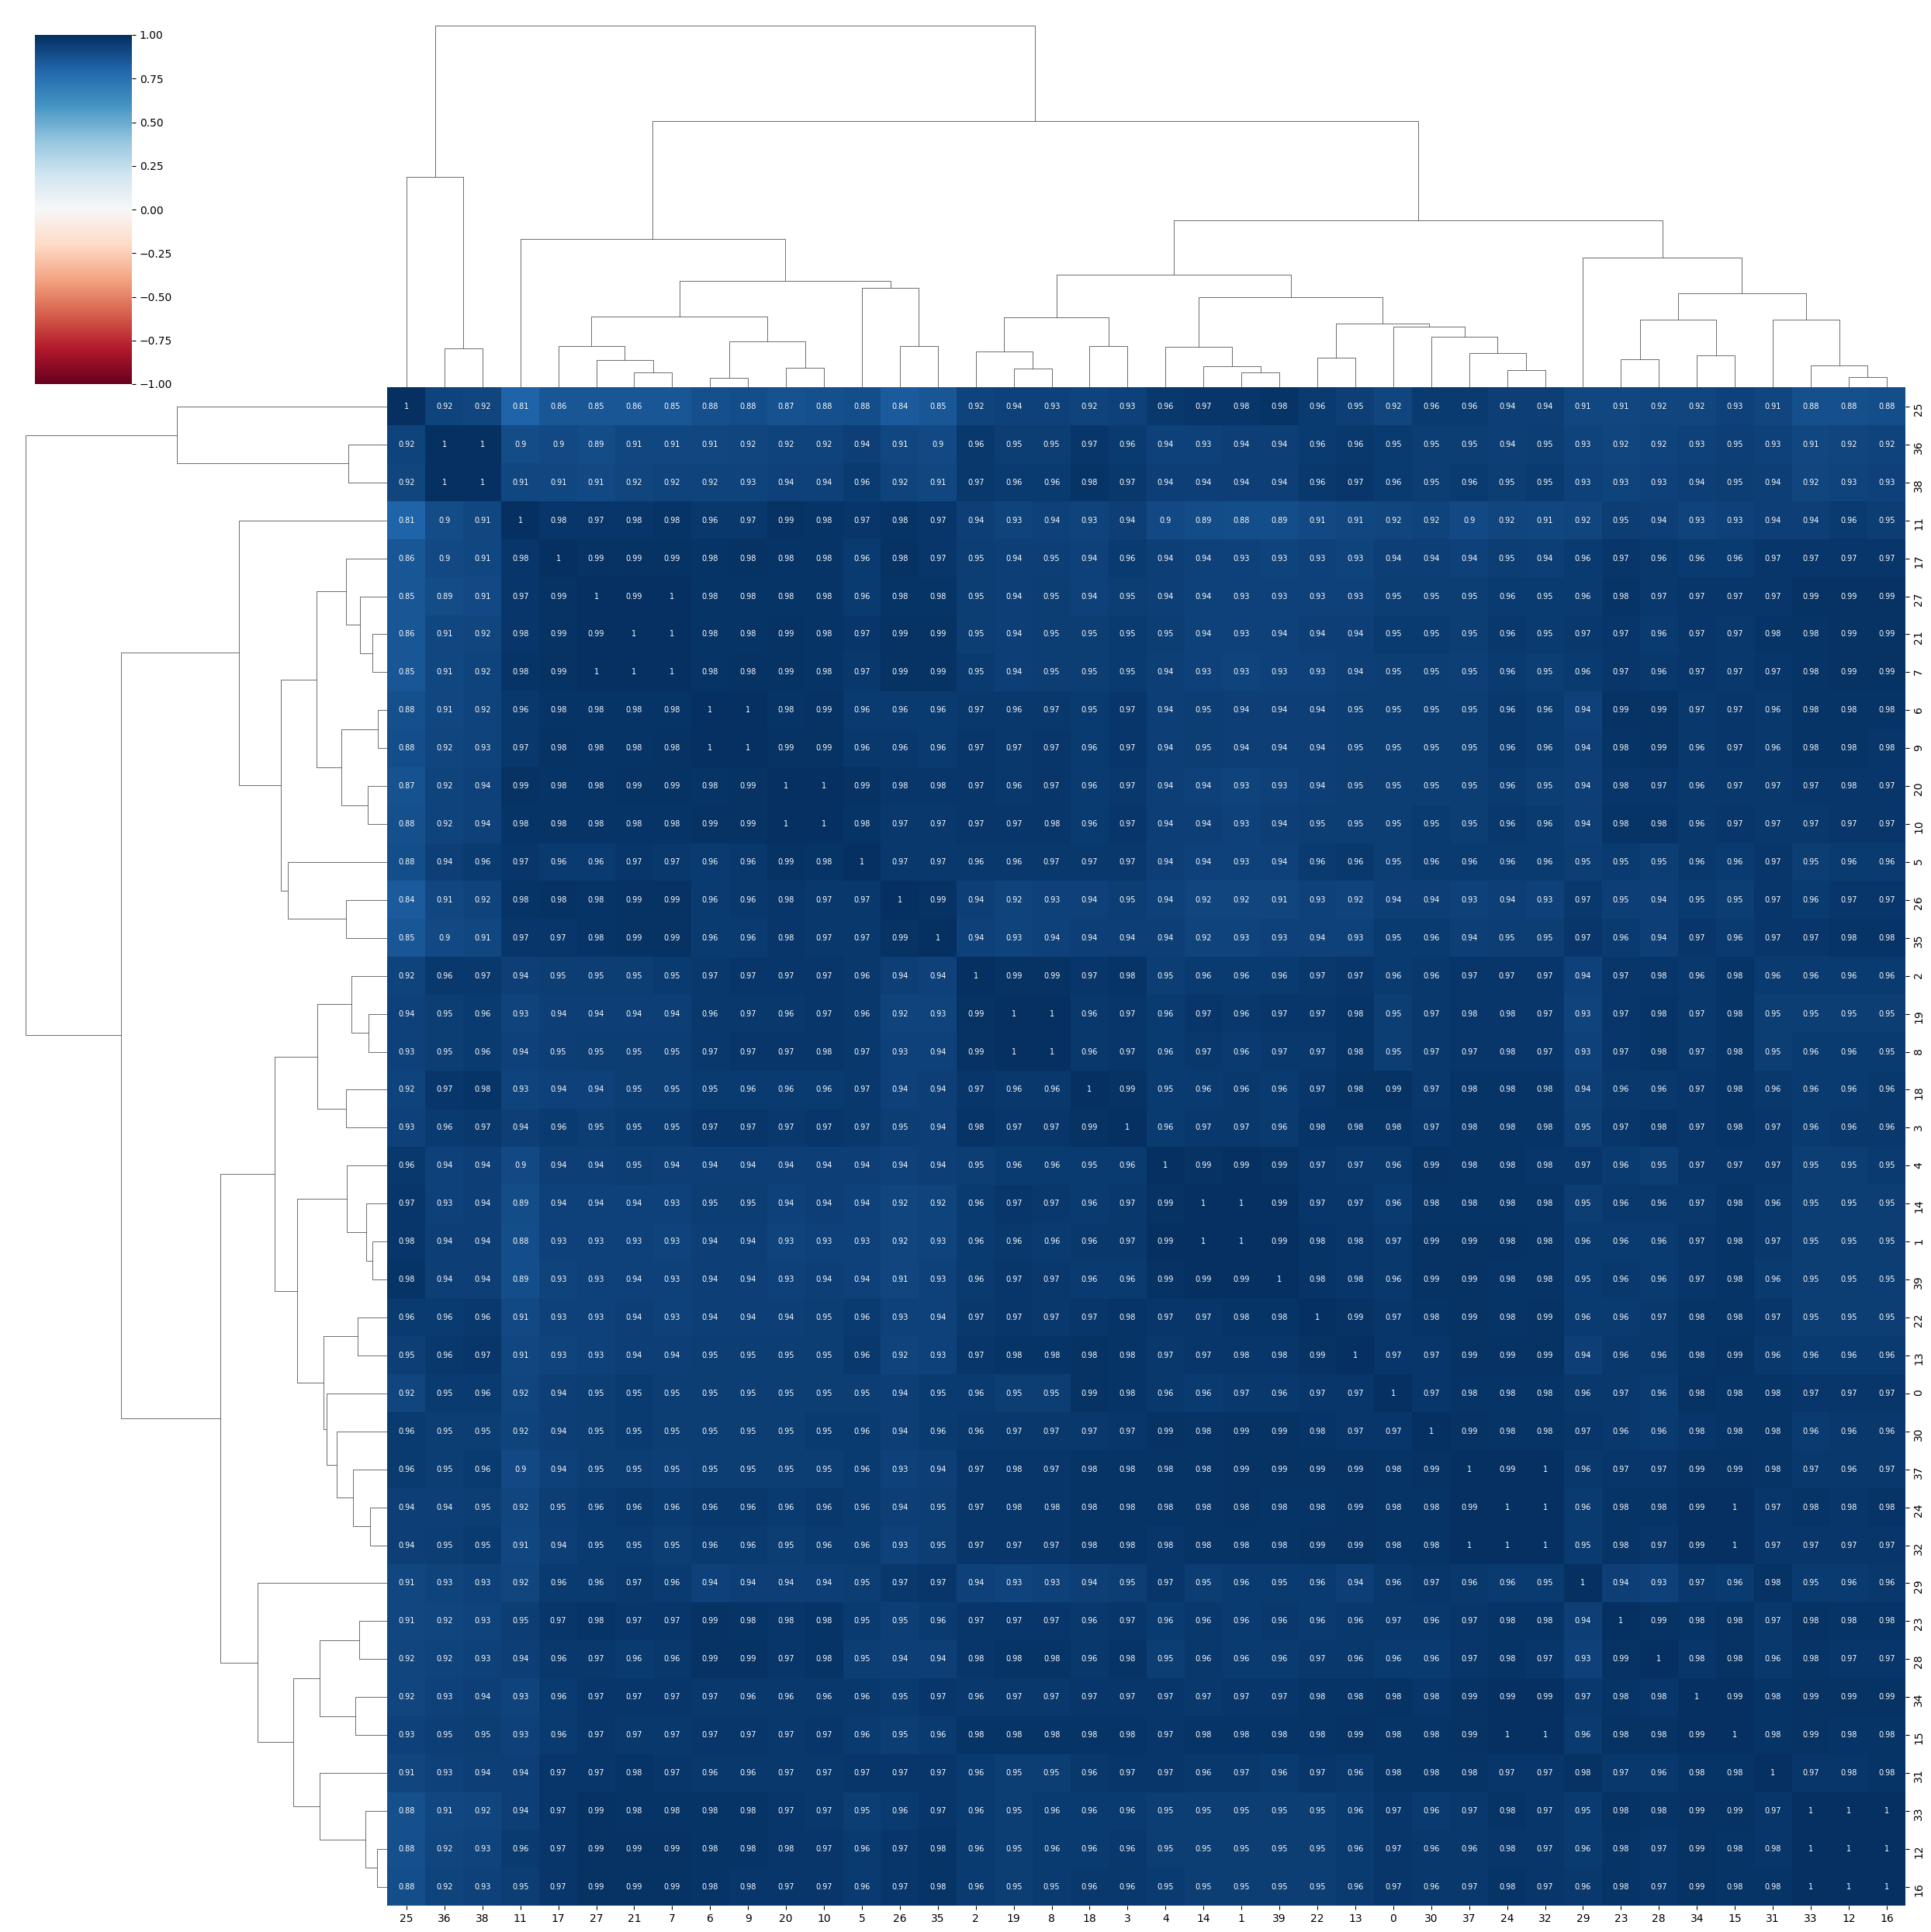

In [18]:
sns.clustermap(correlations1, method="complete", cmap='RdBu', annot=True,
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(25,25));

## Análise dos valores do MAX

<function matplotlib.pyplot.show(close=None, block=None)>

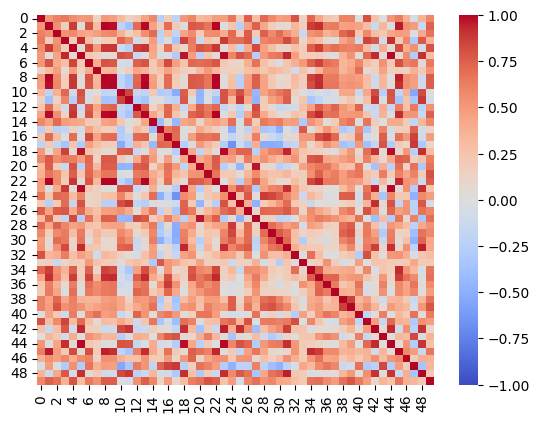

In [19]:
correlation_matrix2 = np.corrcoef(x_transformado[:,1:100:2].T)#todas as linhas, colunas de 1 a 36 pulando de 2 em 2(1,3,5,7,.. ímpares valores MAX)
sns.heatmap(correlation_matrix2, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

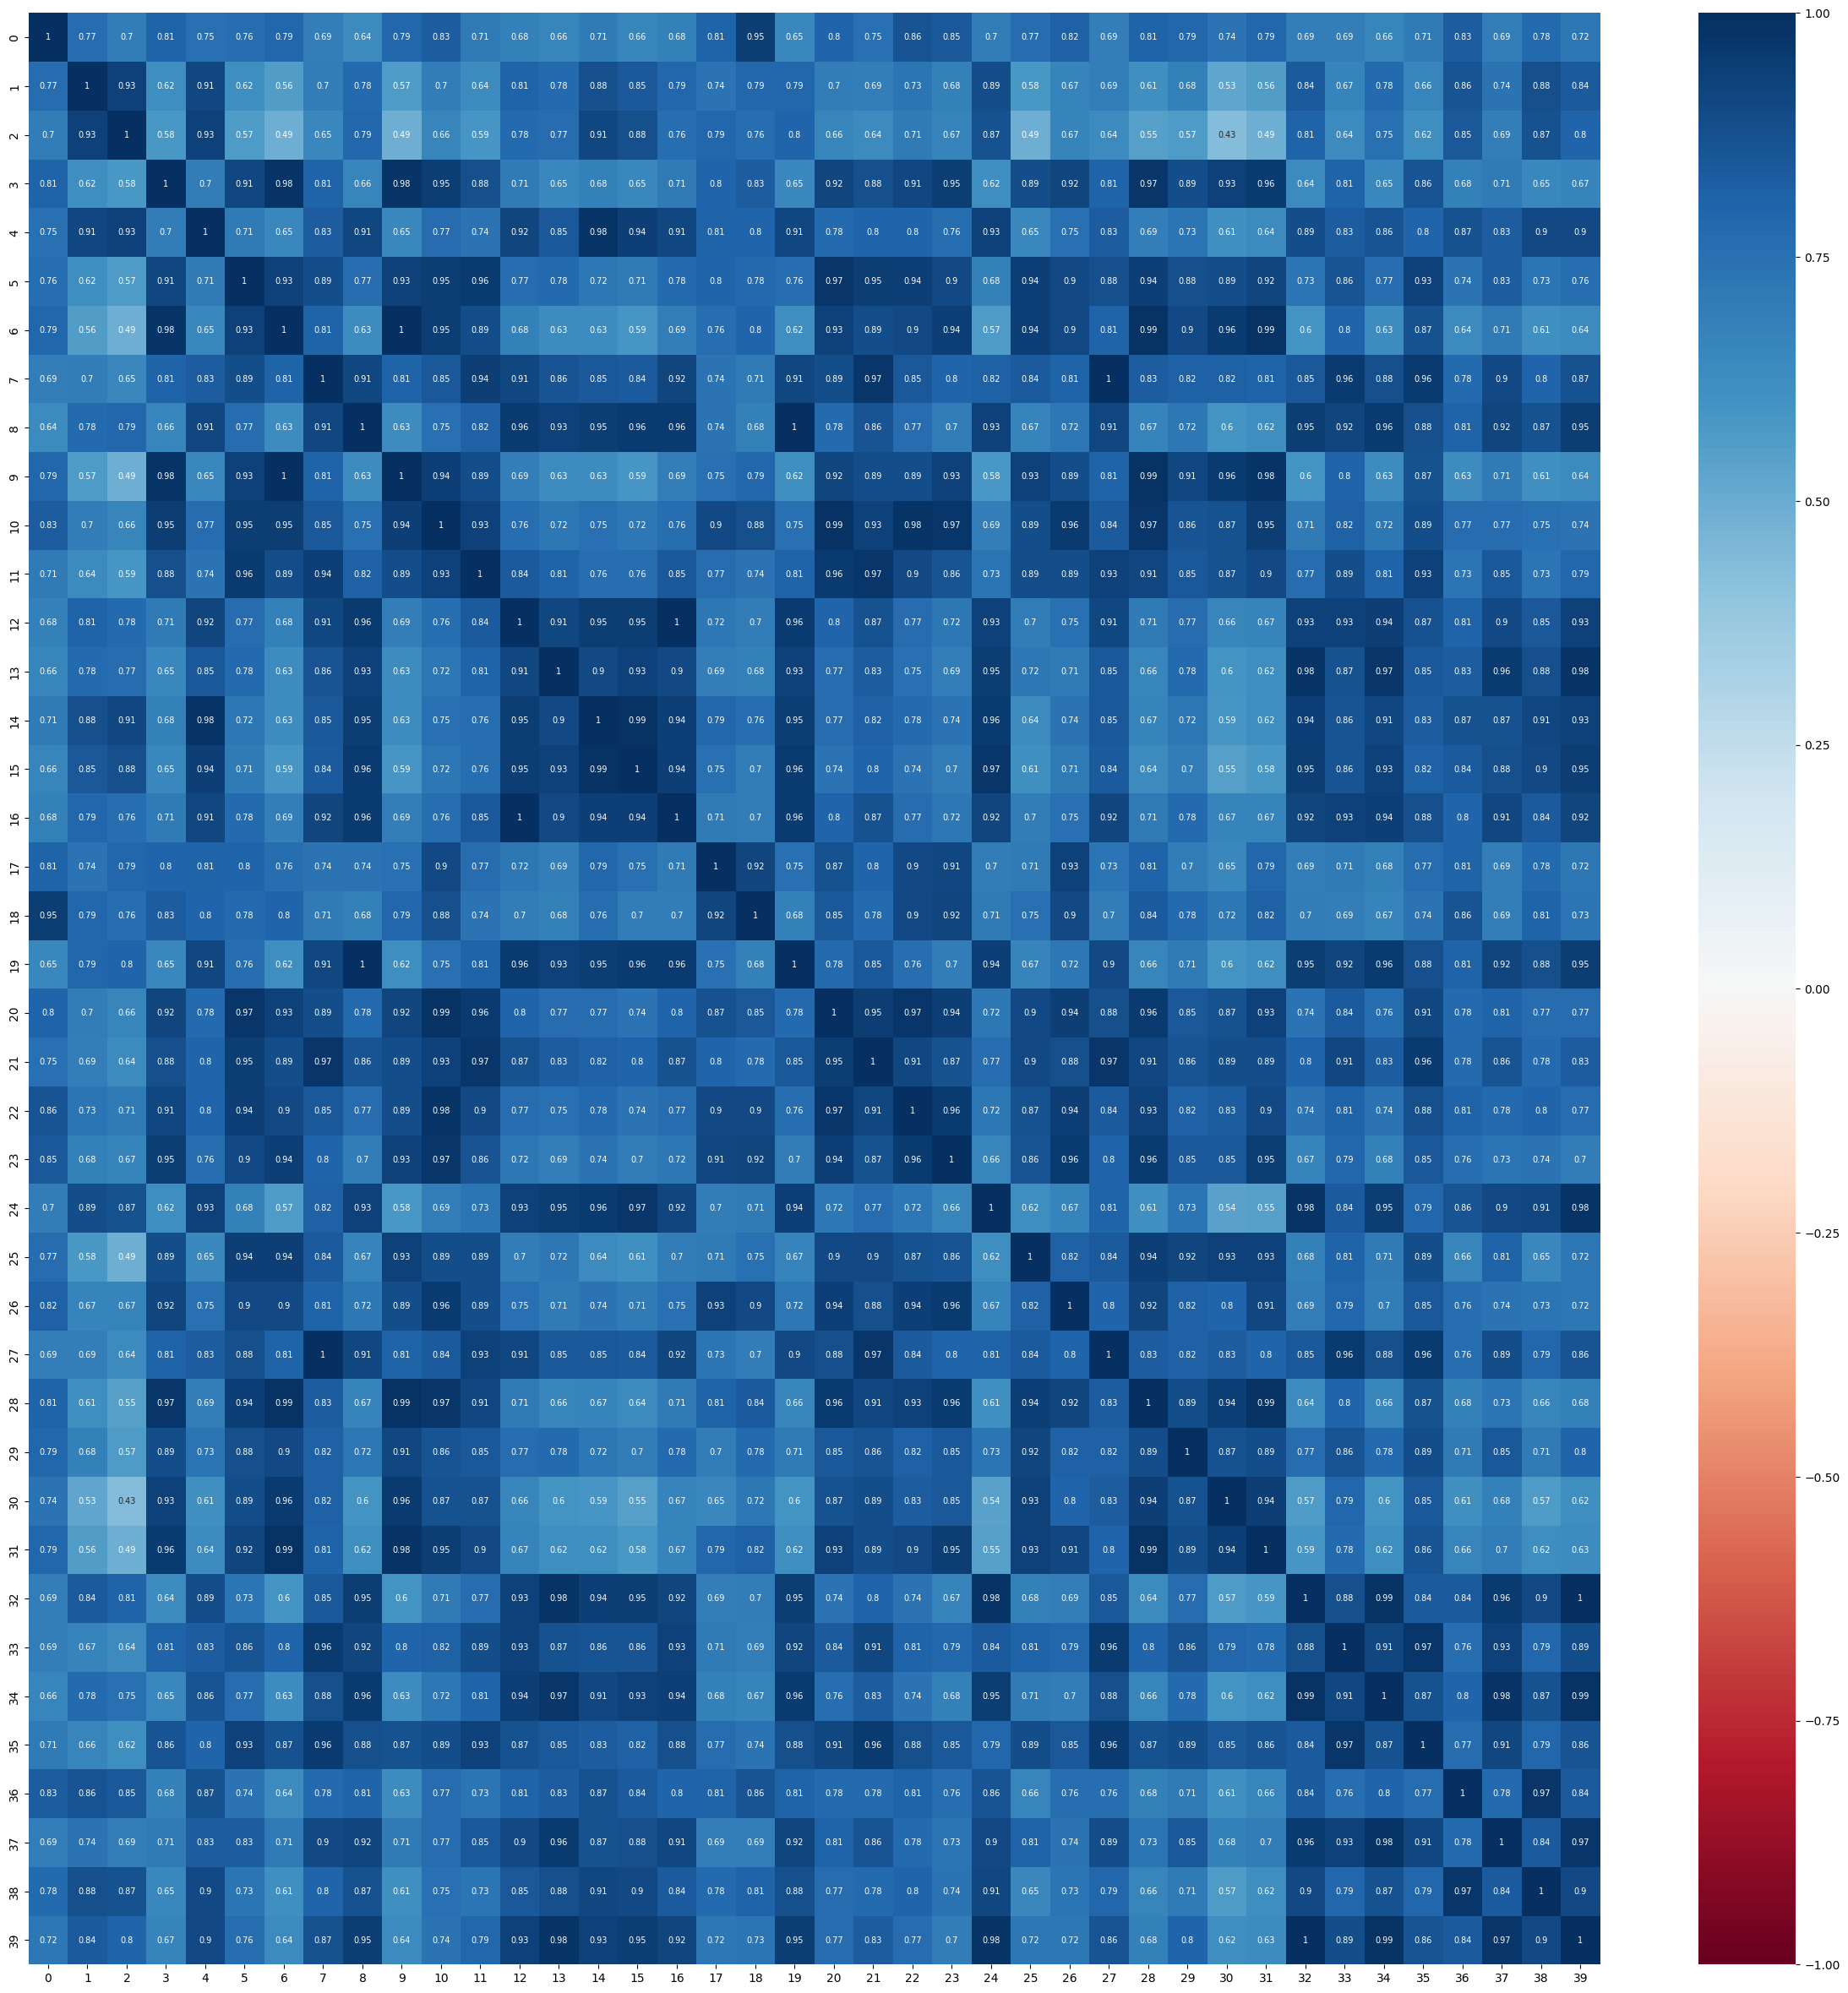

In [20]:
ecg200max = pd.DataFrame(x_transformado[:,1:100:2].T)
plt.figure(figsize=(30,30))
correlations2 = ecg200max.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

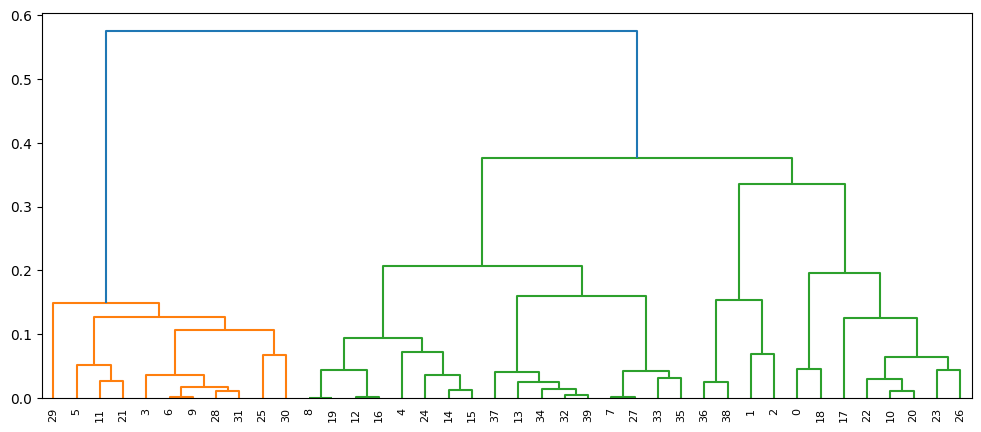

In [21]:
plt.figure(figsize=(12,5))
dissimilarity2 = 1 - abs(correlations2)
Z = linkage(squareform(dissimilarity2), 'complete')

dendrogram(Z, labels=ecg200max.columns, orientation='top',
           leaf_rotation=90);

In [22]:
# Clusterize the data
threshold = 0.000005
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([33, 31, 32,  8, 19,  3,  4, 25, 12,  5, 35,  1, 14, 23, 16, 17, 15,
       40, 34, 13, 36,  2, 37, 38, 18,  9, 39, 26,  6, 11, 10,  7, 20, 27,
       22, 28, 29, 24, 30, 21], dtype=int32)

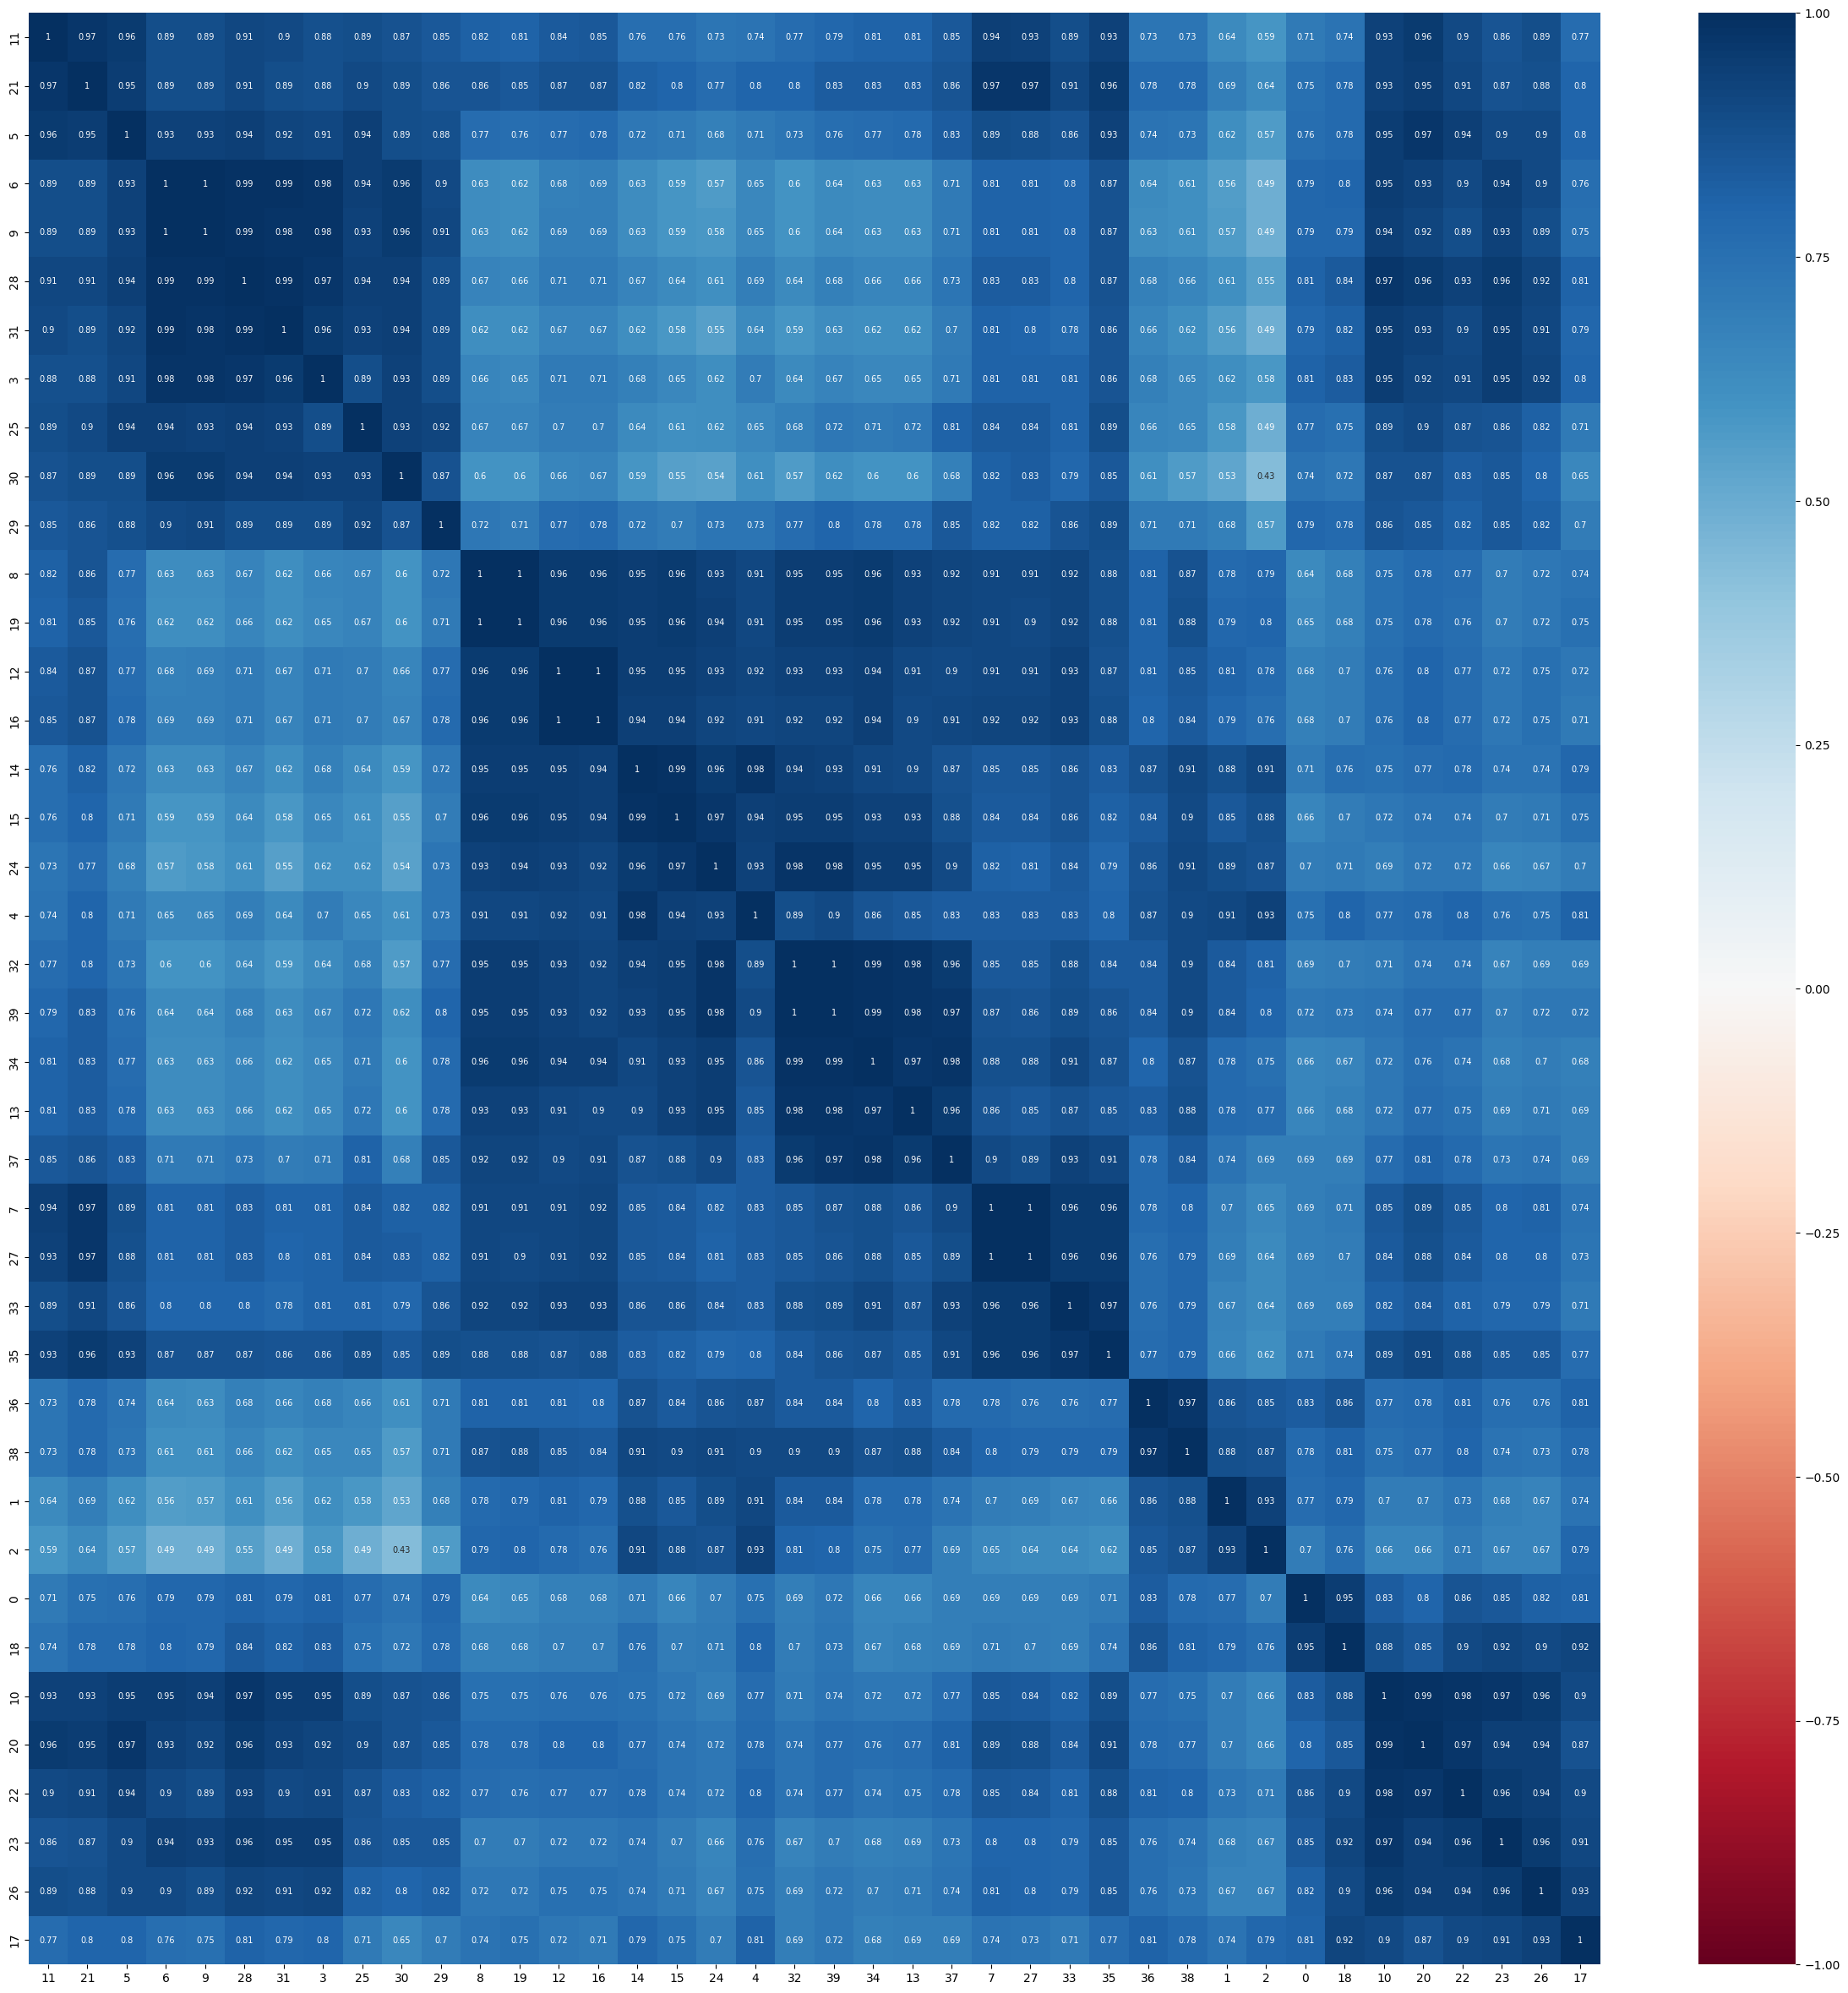

In [23]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(ecg200max.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ecg200max[i])
    else:
        df_to_append = pd.DataFrame(ecg200max[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(30,30))
correlations2 = clustered.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

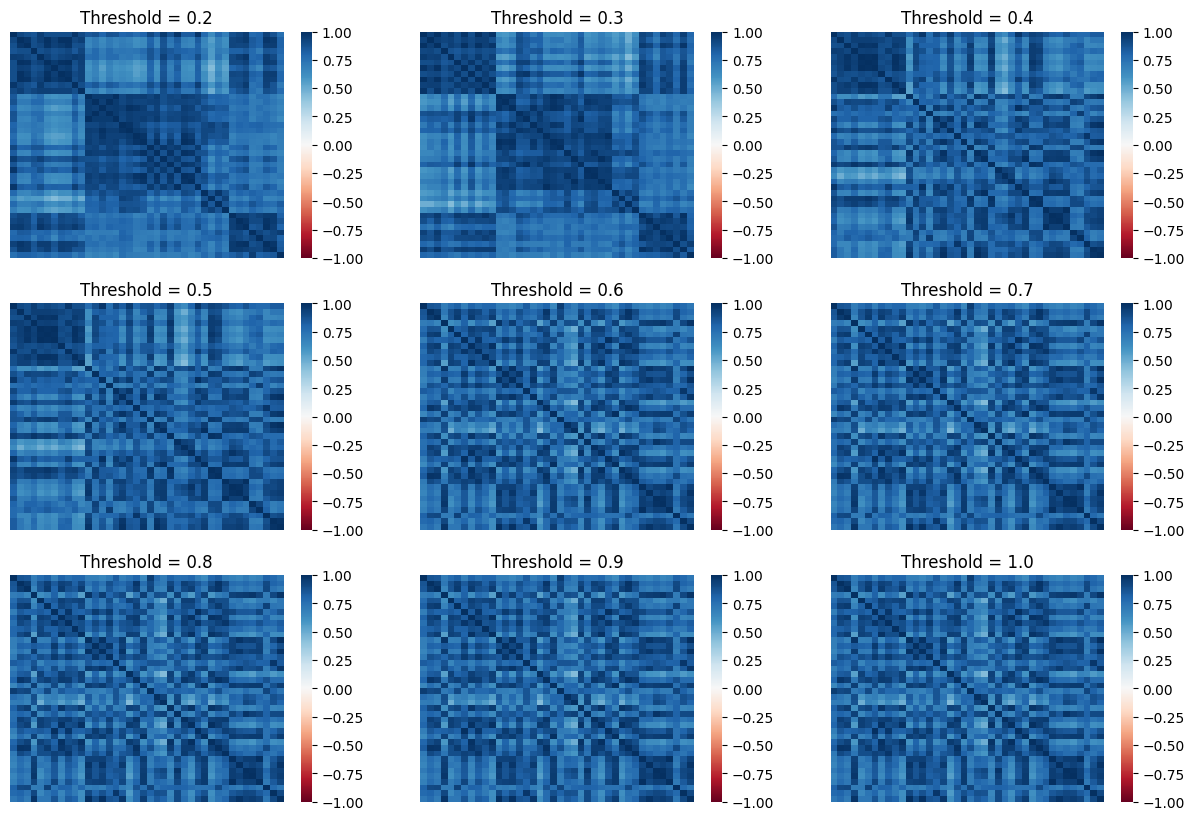

In [24]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):

    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)

    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(ecg200max.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(ecg200max[i])
        else:
            df_to_append = pd.DataFrame(ecg200max[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    # Plot the correlation heatmap
    correlations2 = clustered.corr()
    sns.heatmap(round(correlations2,2), cmap='RdBu', vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))

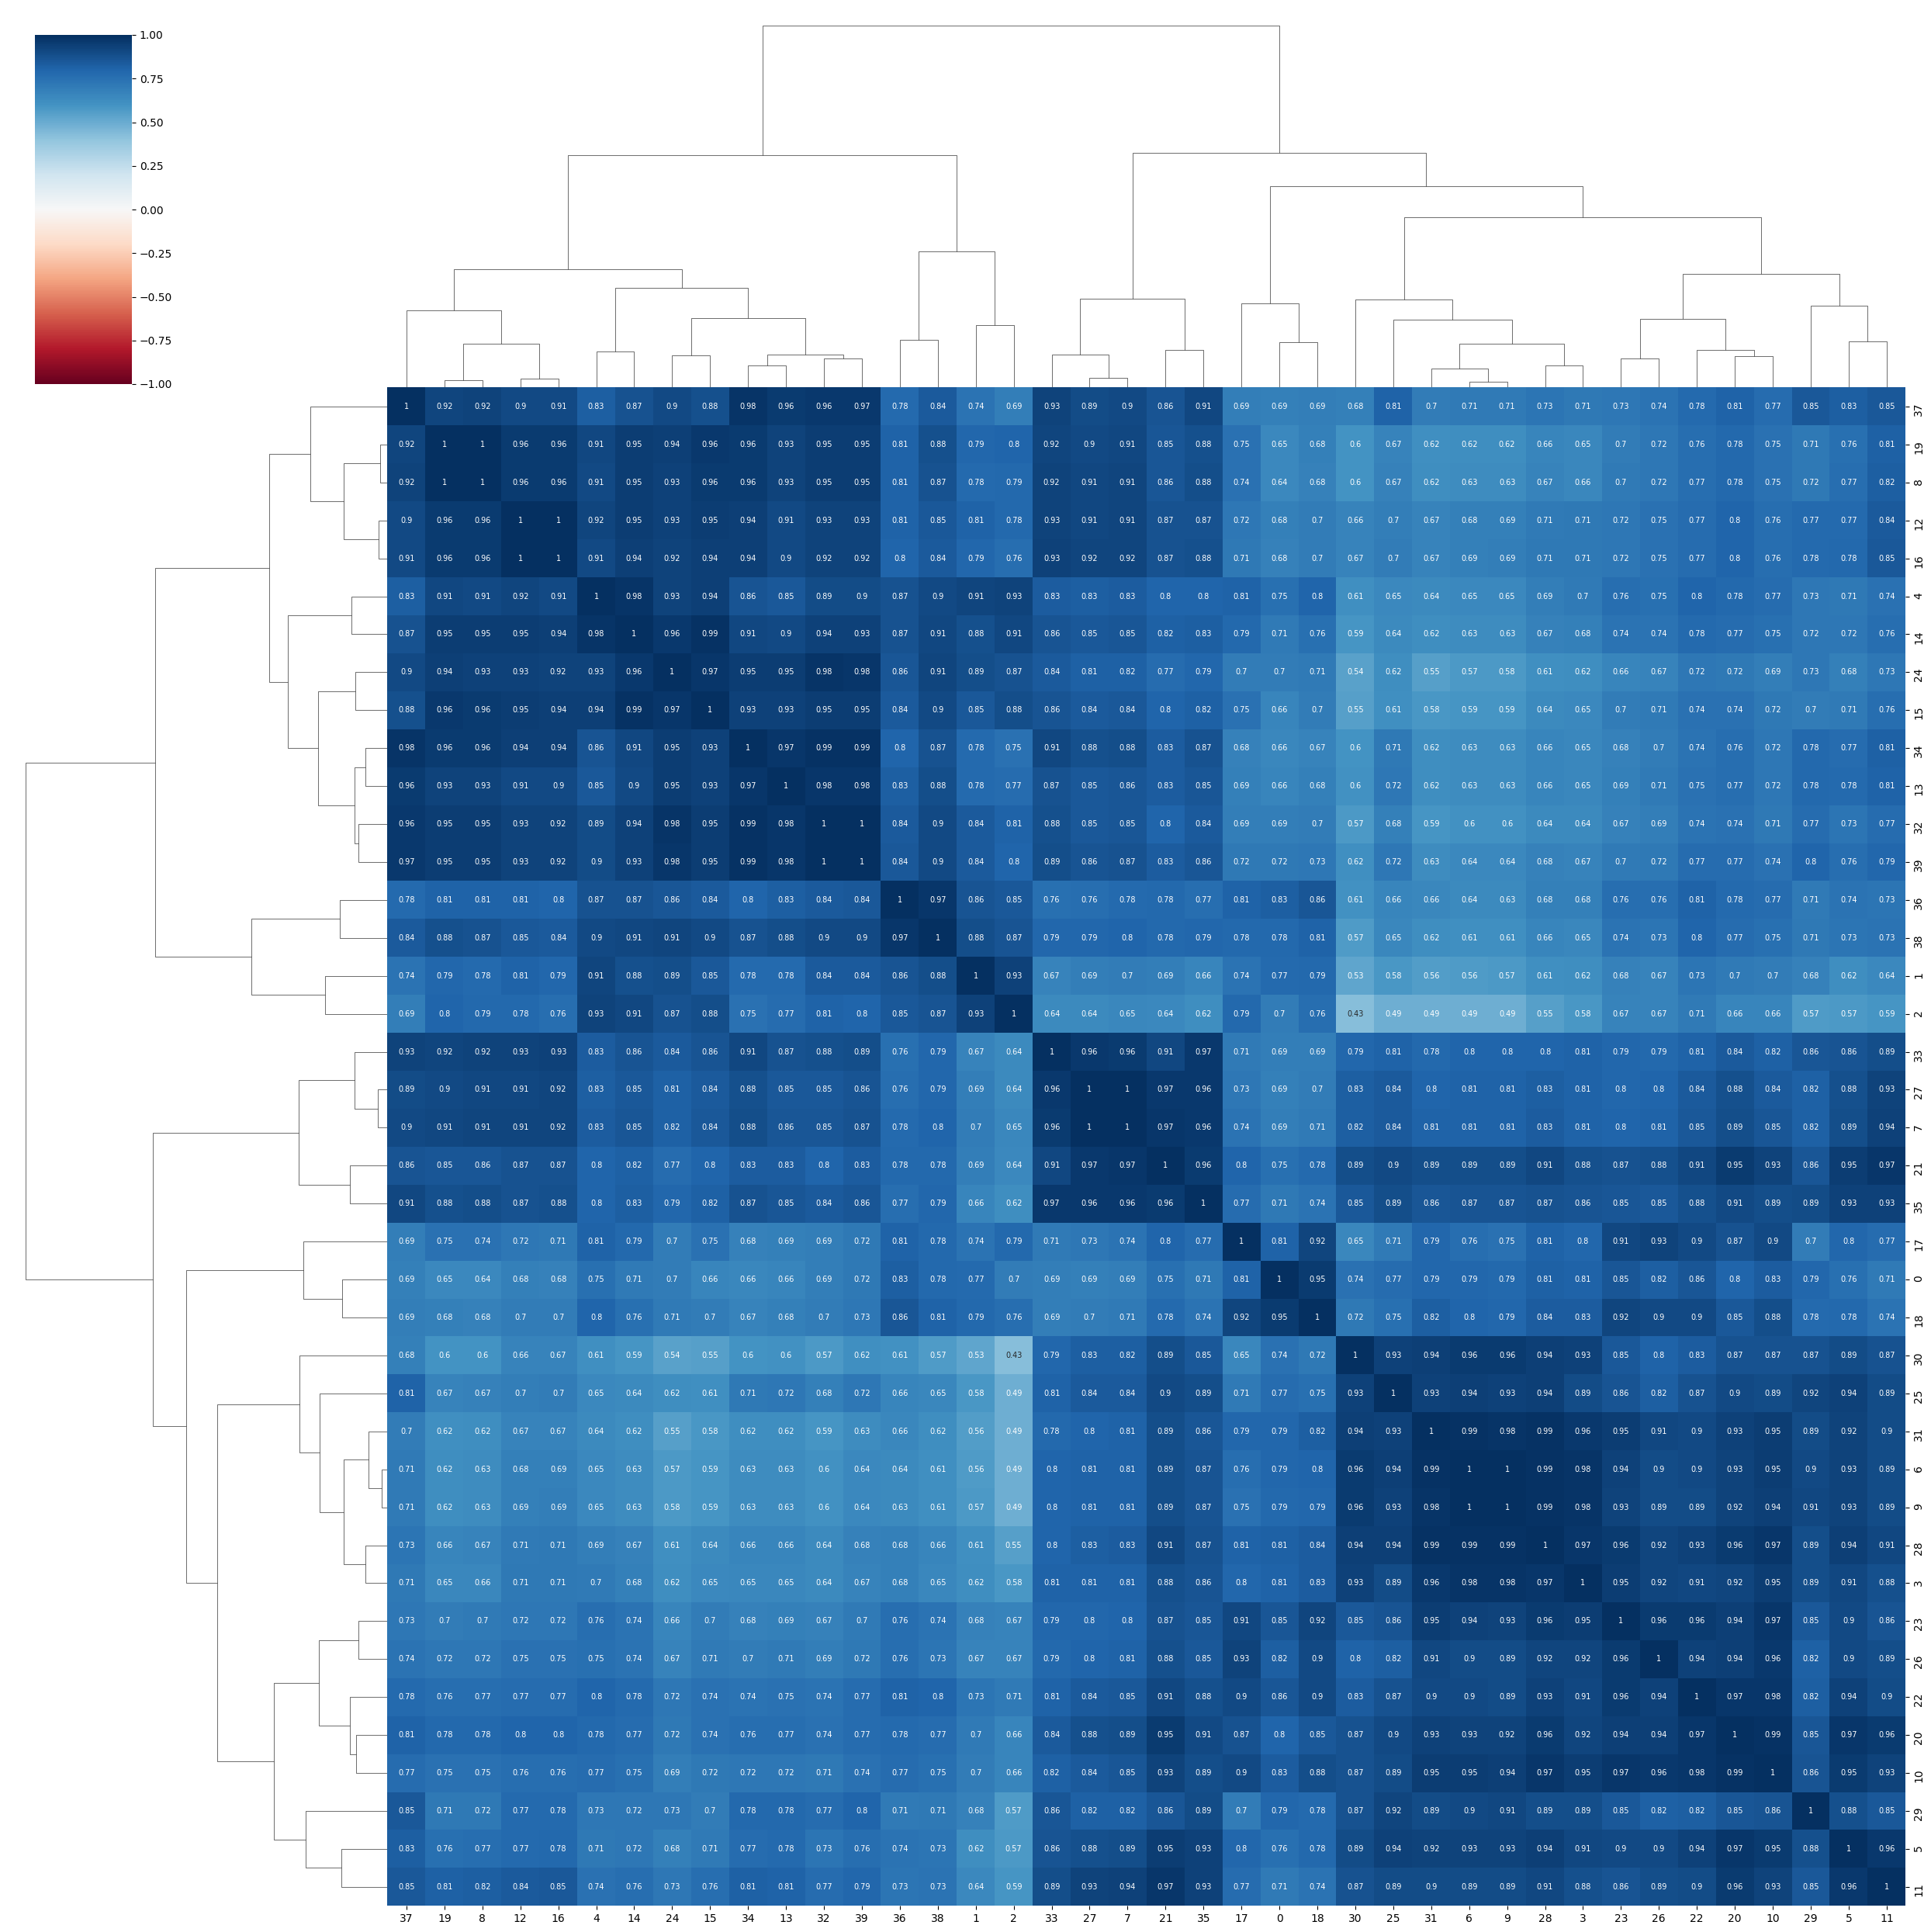

In [25]:
sns.clustermap(correlations2, method="complete", cmap='RdBu', annot=True,
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(25,25));